### Sample program for English to French translation based on seq2seq using LSTM (training)
- based on: https://keras.io/examples/lstm_seq2seq/  

#### Import libraries  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

2021-10-13 20:33:50.539605: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-13 20:33:50.539635: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Parameters  

In [2]:
batch_size = 64  # Batch size for training.
epochs = 500  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 3000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra-eng/fra.txt'

np.random.seed(31)
tf.random.set_seed(31)

#### Read data from file  

In [3]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()

In [4]:
print(len(lines))

170651


In [5]:
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [6]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 3000
Number of unique input tokens: 64
Number of unique output tokens: 86
Max sequence length for inputs: 12
Max sequence length for outputs: 40


In [7]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

print(input_token_index)  # debug
print(target_token_index)  # debug

{' ': 0, '!': 1, '$': 2, "'": 3, ',': 4, '.': 5, '0': 6, '1': 7, '3': 8, '5': 9, '7': 10, '8': 11, '9': 12, ':': 13, '?': 14, 'A': 15, 'B': 16, 'C': 17, 'D': 18, 'E': 19, 'F': 20, 'G': 21, 'H': 22, 'I': 23, 'J': 24, 'K': 25, 'L': 26, 'M': 27, 'N': 28, 'O': 29, 'P': 30, 'R': 31, 'S': 32, 'T': 33, 'U': 34, 'V': 35, 'W': 36, 'Y': 37, 'a': 38, 'b': 39, 'c': 40, 'd': 41, 'e': 42, 'f': 43, 'g': 44, 'h': 45, 'i': 46, 'j': 47, 'k': 48, 'l': 49, 'm': 50, 'n': 51, 'o': 52, 'p': 53, 'q': 54, 'r': 55, 's': 56, 't': 57, 'u': 58, 'v': 59, 'w': 60, 'x': 61, 'y': 62, 'z': 63}
{'\t': 0, '\n': 1, ' ': 2, '!': 3, "'": 4, ',': 5, '-': 6, '.': 7, '0': 8, '1': 9, '3': 10, '5': 11, '8': 12, '9': 13, ':': 14, '?': 15, 'A': 16, 'B': 17, 'C': 18, 'D': 19, 'E': 20, 'F': 21, 'G': 22, 'H': 23, 'I': 24, 'J': 25, 'K': 26, 'L': 27, 'M': 28, 'N': 29, 'O': 30, 'P': 31, 'Q': 32, 'R': 33, 'S': 34, 'T': 35, 'U': 36, 'V': 37, 'Y': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48,

In [8]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.

In [9]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

2021-10-13 20:33:52.433411: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-13 20:33:52.433441: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-13 20:33:52.433461: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (anhvu): /proc/driver/nvidia/version does not exist
2021-10-13 20:33:52.433832: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
%%time

# early stopping and model checkpoint
es = EarlyStopping(monitor='val_loss',
                   patience=10, verbose=1, mode='auto')

fit_log = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs, callbacks=[es],
                    validation_split=0.2)

2021-10-13 20:33:53.172789: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500
38/38 [==============================] - 7s 127ms/step - loss: 1.8919 - accuracy: 0.5973 - val_loss: 1.6381 - val_accuracy: 0.5864
Epoch 2/500
38/38 [==============================] - 4s 99ms/step - loss: 1.4354 - accuracy: 0.6296 - val_loss: 1.4623 - val_accuracy: 0.6030
Epoch 3/500
38/38 [==============================] - 4s 108ms/step - loss: 1.3401 - accuracy: 0.6440 - val_loss: 1.4242 - val_accuracy: 0.6078
Epoch 4/500
38/38 [==============================] - 5s 129ms/step - loss: 1.2213 - accuracy: 0.6643 - val_loss: 1.2959 - val_accuracy: 0.6372
Epoch 5/500
38/38 [==============================] - 4s 118ms/step - loss: 1.1330 - accuracy: 0.6922 - val_loss: 1.1936 - val_accuracy: 0.6739
Epoch 6/500
38/38 [==============================] - 4s 112ms/step - loss: 1.0677 - accuracy: 0.7168 - val_loss: 1.1182 - val_accuracy: 0.6983
Epoch 7/500
38/38 [==============================] - 4s 113ms/step - loss: 0.9546 - accuracy: 0.7404 - val_loss: 1.0288 - val_accuracy: 0.7130


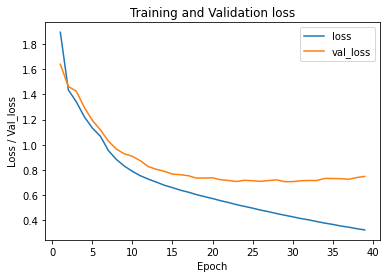

In [12]:
# Plot Training loss & Validation Loss
loss = fit_log.history["loss"]
val_loss = fit_log.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, label="loss" )
plt.plot(epochs, val_loss, label="val_loss")
plt.title("Training and Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss / Val_loss')
plt.legend()
plt.show()

In [13]:
# Save model
model_file = 's2s-eng2fra-'+str(num_samples)+'.h5'
model.save(model_file)
print('Model saved into:', model_file)

Model saved into: s2s-eng2fra-3000.h5
